In [1]:
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
from datasets import Dataset

C:\Users\nine_\Anaconda\anaconda3\envs\torch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Vérification que je suis bien sur mon GPU et non mon CPU
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2070


In [3]:
import pandas as pd

# Récupération des données
# > On récupère les données sur lesquelles nous avons supprimé les doublons, les balises HTML, les URL, et où nous avons normaliser le texte avec UNICODE
# > Cependant, on ne prend pas le jeu de données travaillées sur lequel nous avons déjà supprimé les stopwords, lemmatisé et équilibré les classes

df_traduit = pd.read_csv("fichier_traduit.csv")
df = df_traduit.drop(columns=['merged', 'nb_caracteres', 'langue', 'merged_tronq', 'merged_corr'])
df['merged'] = df['merged_tronq_trad'].fillna("")
df = df.drop(columns=["merged_tronq_trad"])
df.head()

,productid,imageid,prdtypecode,merged
0,3804725264,1263597046,10,olivia : carnet de notes personnalisé / 150 pa...
1,436067568,1008141237,2280,journal des arts (le) ndeg 133 du 28/09/2001 -...
2,201115110,938777978,50,grand stylet ergonomique bleu gamepad nintendo...
3,50418756,457047496,1280,peluche donald - europe - disneyland 2000 (mar...
4,278535884,1077757786,2705,la guerre des tuques - luc a des idées de gran...


In [4]:
# On retravaille prdtypecode afin d'avoir une liste d'entier de 0 à 26 comme labels

label2id = {label: idx for idx, label in enumerate(sorted(df["prdtypecode"].unique()))}
id2label = {v: k for k, v in label2id.items()}  # maping inverse pour plus tard

df["label"] = df["prdtypecode"].map(label2id)
df.head()

,productid,imageid,prdtypecode,merged,label
0,3804725264,1263597046,10,olivia : carnet de notes personnalisé / 150 pa...,0
1,436067568,1008141237,2280,journal des arts (le) ndeg 133 du 28/09/2001 -...,18
2,201115110,938777978,50,grand stylet ergonomique bleu gamepad nintendo...,2
3,50418756,457047496,1280,peluche donald - europe - disneyland 2000 (mar...,7
4,278535884,1077757786,2705,la guerre des tuques - luc a des idées de gran...,25


In [5]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df["merged"], df["label"], test_size=0.2, stratify=df["label"], random_state=25)


# Tokenization
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Converti le Dataset HuggingFace
train_dataset = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()})
test_dataset = Dataset.from_dict({"text": X_test.tolist(), "label": y_test.tolist()})

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

C:\Users\nine_\Anaconda\anaconda3\envs\torch-env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████████████████████████████████████████████████████████| 16693/16693 [00:02<00:00, 6592.16 examples/s]


In [6]:
# Chargement du modèle pré-entrainé
num_labels = len(df["label"].unique())
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Entrainement du modèle
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./Model_Bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.670000,0.573672
2,0.539100,0.512338
3,0.277200,0.488195
4,0.212800,0.530827
5,0.243900,0.563854


TrainOutput(global_step=20870, training_loss=0.41919200548756674, metrics={'train_runtime': 34582.3344, 'train_samples_per_second': 9.654, 'train_steps_per_second': 0.603, 'total_flos': 5.850801276524352e+16, 'train_loss': 0.41919200548756674, 'epoch': 5.0})

In [8]:
# Sauvegarde du modèle et des logs
import json

model.save_pretrained("./Model_Bert")
tokenizer.save_pretrained("./Model_Bert")

with open("training_logs.json", "w") as f:
    json.dump(trainer.state.log_history, f)

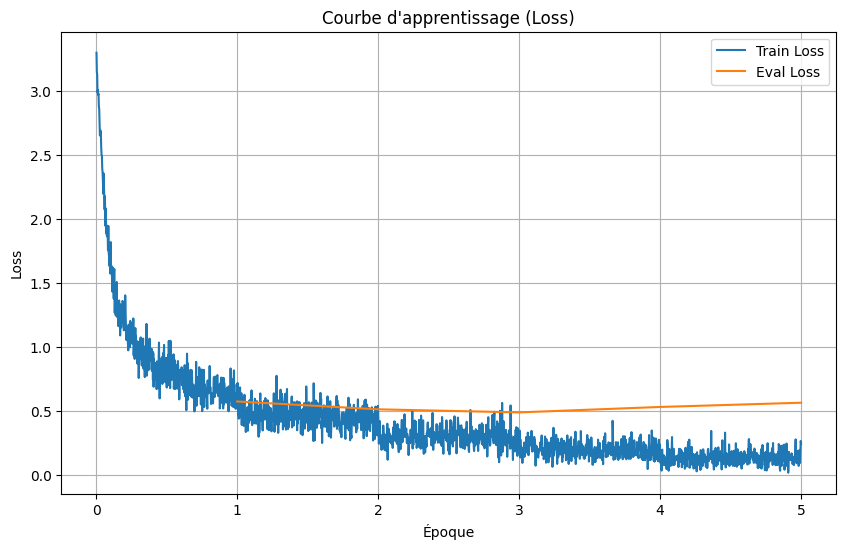

In [11]:
import matplotlib.pyplot as plt

# COURBE DE LOSS

# Chargement des logs depuis le fichier JSON
with open("training_logs.json", "r") as f:
    logs = json.load(f)


# Initialisation des listes
train_loss = []
eval_loss = []
train_epochs = []
eval_epochs = []

# Extraire les valeurs de loss et les époques
for log in logs:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    elif "eval_loss" in log and "epoch" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])

# Tracer la courbe de loss
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_loss, label="Train Loss")
plt.plot(eval_epochs, eval_loss, label="Eval Loss")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Courbe d'apprentissage (Loss)")
plt.legend()
plt.grid(True)
plt.show()   

Train Loss : 
- La courbe décroît rapidement au début. Le modèle apprend efficacement à réduire l'erreur sur les données d'entraînement.
- La courbe continue de baisser de manière régulière jusqu'à la fin : le modèle devient de plus en plus performant sur les données d'entraînement.

Eval Loss : 
- La courbe stagne, puis augmente légèrement après la 2ème époque. L'écart avec la courbe Train Loss augmente après la 2ème époque.
- Cela indique un début de surapprentissage. Le modèle continue de s'améliorer sur les données d'entraînement, mais ne généralise plus bien aux données de validation.

In [30]:
# Fonction d'ajout des metrics pour Trainer

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    # Décompose les sorties du modèle
    predictions, labels = eval_pred
    
    # Transforme les logits en classes prédictes
    preds = predictions.argmax(axis=1)
    
    # Calcule les métriques pondérées
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    # Calcule l'accuracy globale
    acc = accuracy_score(labels, preds)
    
    # Retourne les métriques
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [32]:
# On réentraine le modèle, en ayant cette fois les métrics dans le trainer, et en mettant le nombre d'Epochs = 2 
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./Model_Bert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.204200,0.631619,0.867070,0.868221,0.867070,0.865722
2,0.010700,0.696603,0.874678,0.874562,0.874678,0.874434


TrainOutput(global_step=8348, training_loss=0.12622417522273927, metrics={'train_runtime': 33728.0402, 'train_samples_per_second': 3.959, 'train_steps_per_second': 0.248, 'total_flos': 2.339559393854202e+16, 'train_loss': 0.12622417522273927, 'epoch': 2.0})

In [33]:
# Evaluation du modèle 
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.6966025233268738, 'eval_accuracy': 0.8746780087461811, 'eval_precision': 0.8745618160439467, 'eval_recall': 0.8746780087461811, 'eval_f1': 0.8744338027850493, 'eval_runtime': 1073.1745, 'eval_samples_per_second': 15.555, 'eval_steps_per_second': 0.243, 'epoch': 2.0}


In [36]:
# Sauvegarde du modèle et des logs
import json

model.save_pretrained("./Model_Bert")
tokenizer.save_pretrained("./Model_Bert")

with open("training_logs2.json", "w") as f:
    json.dump(trainer.state.log_history, f)

Eval epochs: 3, Eval loss: 3, Accuracy: 3, F1: 3


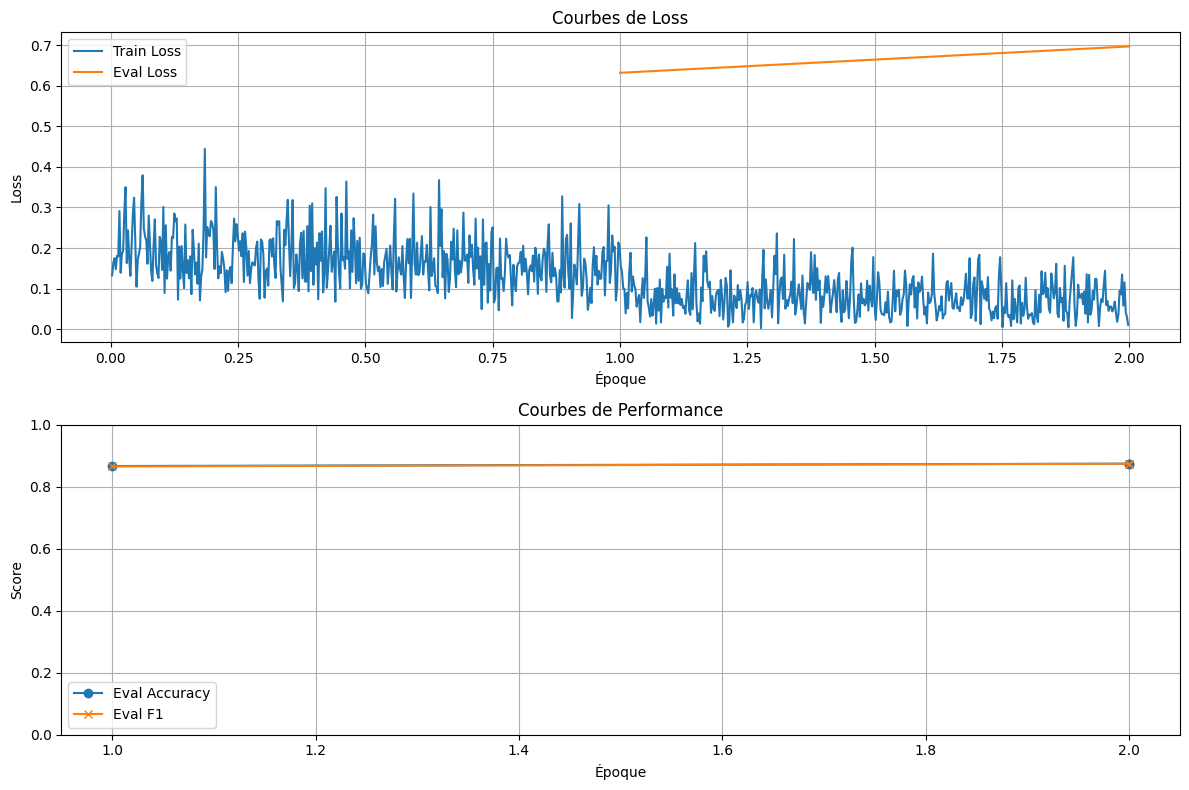

In [37]:
# Charger les logs
with open("training_logs2.json", "r") as f:
    logs = json.load(f)

# Initialisation
train_loss = []
train_epochs = []
eval_loss = []
eval_accuracy = []
eval_f1 = []
eval_epochs = []

# Extraction des données
for log in logs:
    # Loss d'entraînement
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    
    # Métriques d'évaluation
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # on suppose ici que 'epoch' est présent
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])
    if "eval_f1" in log:
        eval_f1.append(log["eval_f1"])

# Vérification des longueurs
print(f"Eval epochs: {len(eval_epochs)}, Eval loss: {len(eval_loss)}, Accuracy: {len(eval_accuracy)}, F1: {len(eval_f1)}")

# Tracé
plt.figure(figsize=(12, 8))

# Loss
plt.subplot(2, 1, 1)
plt.plot(train_epochs, train_loss, label="Train Loss")
plt.plot(eval_epochs, eval_loss, label="Eval Loss")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.title("Courbes de Loss")
plt.legend()
plt.grid(True)

# Accuracy et F1
plt.subplot(2, 1, 2)
if len(eval_accuracy) == len(eval_epochs):
    plt.plot(eval_epochs, eval_accuracy, marker='o', label="Eval Accuracy")
if len(eval_f1) == len(eval_epochs):
    plt.plot(eval_epochs, eval_f1, marker='x', label="Eval F1")
plt.xlabel("Époque")
plt.ylabel("Score")
plt.title("Courbes de Performance")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
print(f"Eval epochs: {len(eval_epochs)}, Eval loss: {len(eval_loss)}, Accuracy: {len(eval_accuracy)}, F1: {len(eval_f1)}")

Eval epochs: 5, Eval loss: 5, Accuracy: 0, F1: 0


In [25]:
from sklearn.metrics import classification_report

# Génération des prédictions
predictions_output = trainer.predict(test_dataset)
y_pred = predictions_output.predictions.argmax(axis=1)
y_true = predictions_output.label_ids

# Récupération des classes
label_names = [str(id2label[i]) for i in range(len(id2label))]

# Rapport
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))



              precision    recall  f1-score   support

          10       0.66      0.68      0.67       623
          40       0.79      0.80      0.79       497
          50       0.84      0.90      0.87       329
          60       0.92      0.91      0.91       163
        1140       0.84      0.80      0.82       534
        1160       0.96      0.97      0.97       790
        1180       0.76      0.63      0.69       153
        1280       0.77      0.78      0.78       969
        1281       0.70      0.72      0.71       408
        1300       0.98      0.98      0.98      1001
        1301       0.92      0.96      0.94       139
        1302       0.82      0.86      0.84       475
        1320       0.86      0.84      0.85       645
        1560       0.90      0.87      0.88      1001
        1920       0.90      0.94      0.92       816
        1940       0.88      0.96      0.92       160
        2060       0.87      0.83      0.85       970
        2220       0.85    

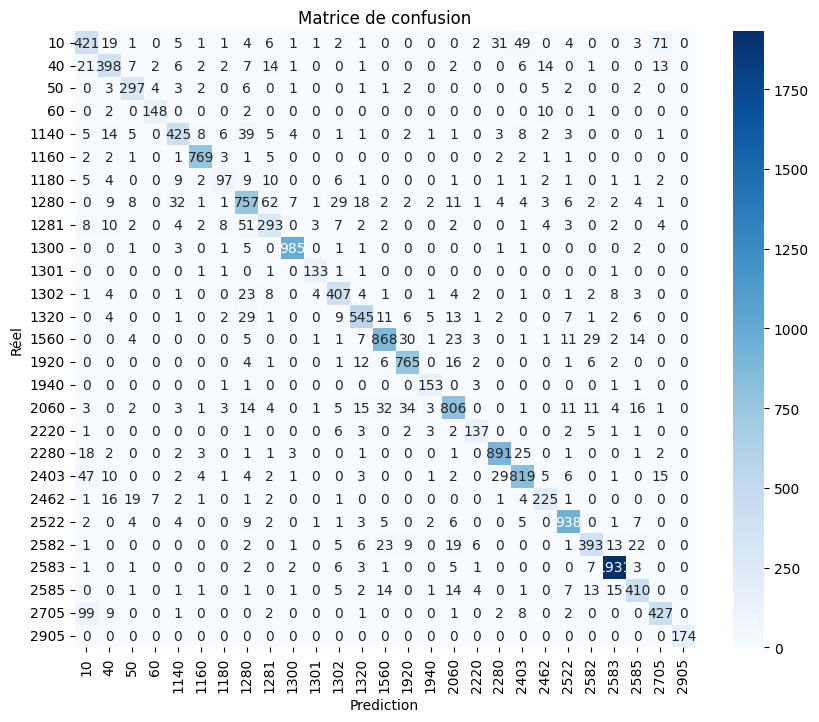

In [26]:
# Matrice de confusion

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Prediction")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


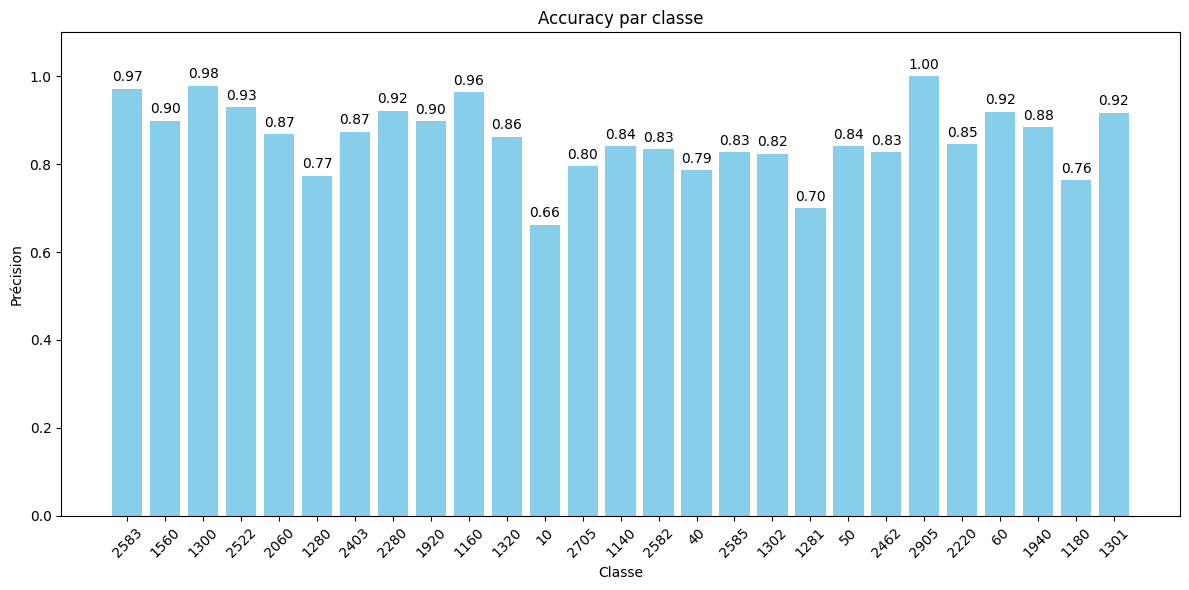

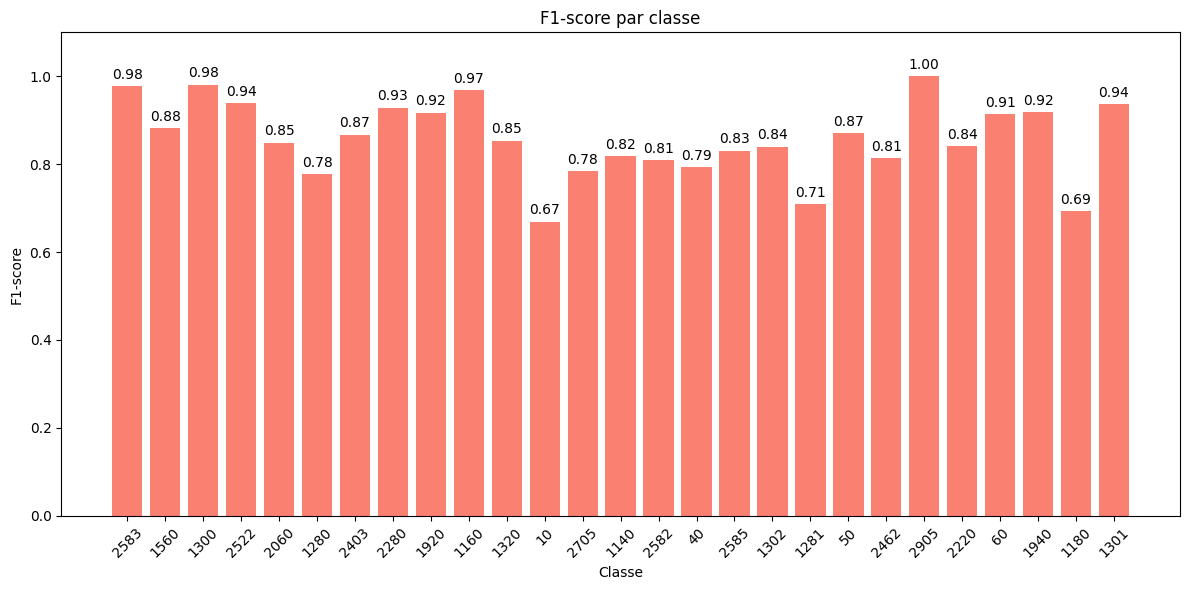

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=range(len(label_names)))

report_df = pd.DataFrame({
    'Classe': label_names,
    'Précision': precision,
    'Rappel': recall,
    'F1-score': f1,
    'Support': support
})

report_df = report_df.sort_values(by='Support', ascending=False)


# Graphique Accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(report_df['Classe'], report_df['Précision'], color='skyblue')
plt.ylim(0, 1.1)
plt.title("Accuracy par classe")
plt.ylabel("Précision")
plt.xlabel("Classe")
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()


# Graphique F1-score
plt.figure(figsize=(12, 6))
bars = plt.bar(report_df['Classe'], report_df['F1-score'], color='salmon')
plt.ylim(0, 1.1)
plt.title("F1-score par classe")
plt.ylabel("F1-score")
plt.xlabel("Classe")
plt.xticks(rotation=45)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f"{height:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [28]:
# Quelques exemples d'erreur de prédiction

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

wrong_preds = X_test[y_pred != y_true]
true_labels = [id2label[i] for i in y_true[y_pred != y_true]]
predicted_labels = [id2label[i] for i in y_pred[y_pred != y_true]]

for i in range(5):  # Affiche 5 erreurs
    print(f"\nTexte : {wrong_preds.iloc[i]}")
    print(f"Vrai label : {true_labels[i]} | Prédit : {predicted_labels[i]}")


Texte : atlas elementaire compose de xxxiii cartes... tant des nouvelles decouvertes faites en asie en afrique et en amerique que des nouveaux changemens politiques survenus en europe... precede : 1degdes institutions geographiques et historiques ou des... -
Vrai label : 10 | Prédit : 2403

Texte : pondant des oeufs de poulet en peluche electrique poule musicale danse cadeaux pour bebe enfants - pondant des oeufs de poulet en peluche electrique poule musicale danse bebe cadeaux enfants caracteristiques: crazy chicken toy chant qui pond des ?ufs en dansant chaque forfait comprend: mere poule et 3 oeufs. chicken toy charlatans arrete et pond ses oeufs avec des lumieres sons et musique enseignez a votre enfant a propos de la nature des poulets a travers lumieres et son poulet pose  oeufs  paq
Vrai label : 1280 | Prédit : 1281

Texte : belle couleur beurre slime arc-en-gateau d'anniversaire slime enfants relief jouets stress - belle couleur arc-en-beurre slime gateau d'anniversaire slime 